## Avaliação em holdouts - Amazon Kindle

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Kindle
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((138644, 4), 26936, 99138)

In [6]:
data[['user_id', 'item_id']].duplicated().sum()

609

In [6]:
data.head()

,user_id,item_id,timestamp,date
0,B000FA5PV4,A23NR7891PY2P1,1388534400,2014-01-01
1,B000FC1LLA,A1CBHVD1PG6UUV,1388534400,2014-01-01
2,B000GFK7L6,ARISSM47DJHQ8,1388534400,2014-01-01
3,B000QCS8YM,A1SBCP7BB2QK9T,1388534400,2014-01-01
4,B000VDUWMC,ABSBO832VAJ36,1388534400,2014-01-01


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138644 entries, 0 to 138643
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    138644 non-null  object
 1   item_id    138644 non-null  object
 2   timestamp  138644 non-null  int64 
 3   date       138644 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.2+ MB


### Convert timestamp

In [8]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 1.06 s, sys: 10.1 ms, total: 1.07 s
Wall time: 1.09 s


In [9]:
data.head()

,user_id,item_id,timestamp,date
0,B000FA5PV4,A23NR7891PY2P1,1388534400,2014-01-01
1,B000FC1LLA,A1CBHVD1PG6UUV,1388534400,2014-01-01
2,B000GFK7L6,ARISSM47DJHQ8,1388534400,2014-01-01
3,B000QCS8YM,A1SBCP7BB2QK9T,1388534400,2014-01-01
4,B000VDUWMC,ABSBO832VAJ36,1388534400,2014-01-01


In [10]:
data.tail()

,user_id,item_id,timestamp,date
138639,B017H8DIBK,A1USMDPP0VZJN2,1396224000,2014-03-01
138640,B017H8DIBK,A32G0QFLKW49OK,1396224000,2014-03-01
138641,B017H8DIBK,A38MAEG6QJ0KO4,1396224000,2014-03-01
138642,B0183G04SU,AR3IXZM3MGPYY,1396224000,2014-03-01
138643,B01D6NM4VA,A11GTCPLP371AQ,1396224000,2014-03-01


CPU times: user 72 ms, sys: 2.7 ms, total: 74.7 ms
Wall time: 108 ms


Text(0.5, 1.0, 'interactions per month')

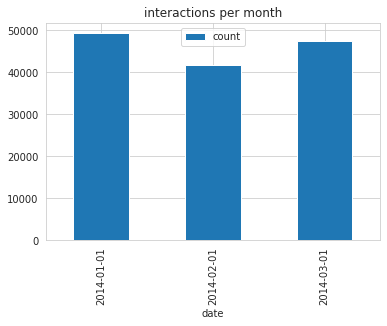

In [11]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [12]:
user_presence_df = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

___
## Experiments using months

In [13]:
data.shape

(138644, 4)

In [14]:
%%time
# 8min 30s
buckets, holdouts = getBucketsHoldouts(
    data=data, # data[ data['date'].dt.month == 1 ],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(), #frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 50
common interactions between holdout 2 and all buckets: 43
common interactions between holdout 3 and all buckets: 46
Converting to ImplicitData. . .
Done!
CPU times: user 5min 32s, sys: 324 ms, total: 5min 33s
Wall time: 5min 40s


Debugging buckets and holdouts - **only works if they're not converted to implicit data in get_buckets_and_holdouts.getBucketsHoldouts**

In [15]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

138644

In [16]:
joblib.dump(buckets, 'output/amazonkindle_dump/2nd_sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazonkindle_dump/2nd_sample_holdouts.joblib')

['output/amazonkindle_dump/2nd_sample_holdouts.joblib']

### ISGD

In [17]:
buckets = joblib.load('output/amazonkindle_dump/2nd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonkindle_dump/2nd_sample_holdouts.joblib')

In [18]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(41612, 15189, 34004), (31479, 10631, 25786), (34959, 10703, 28562)]

In [19]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(7765, 7765, 6944), (10307, 10307, 8992), (12522, 12522, 10851)]

Hyperparameters

In [20]:
# import itertools
# def grid_search(model, stream, random_seed = 10, interleaved=10):    
#     num_factors = [100, 150, 200]
#     num_iter = [2, 5, 8]
#     learn_rate = [0.1, 0.25, 0.5]
#     regularization = [0.3, 0.4, 0.5]
#     num_nodes = [4, 8, 16]
#     grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
#     grid = list(itertools.product(*grid))
#     results = []
#     for i, hp in enumerate(grid):
#         if not ((i*100)/len(grid))%5:
#             print(((i*100)/len(grid)), '%')
#         empty_stream = ImplicitData([], [])
#         nf, ni, lr, reg, nn = hp
#         m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
#         e = EvalPrequential(m, stream, metrics = ["Recall@20"])
#         result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
#         results.append( np.mean(result['Recall@20']) )
#     return grid, results    

# # OPTIONAL FOR NOW
# prop = 0.1
# hp_sample = data.iloc[:round( data.shape[0]*prop )]
# stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
# grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
# len(grid), len(results), max(results)

In [21]:
# define hyperparameters (SAME AS LASTFM) ????
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [22]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [23]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 23.1 µs


In [27]:
%%time
# 8h 31min 2s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 17h 13min 51s, sys: 22h 55min 24s, total: 1d 16h 9min 16s
Wall time: 8h 31min 2s


In [28]:
#0.0 freq T
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD results.csv', index=False)

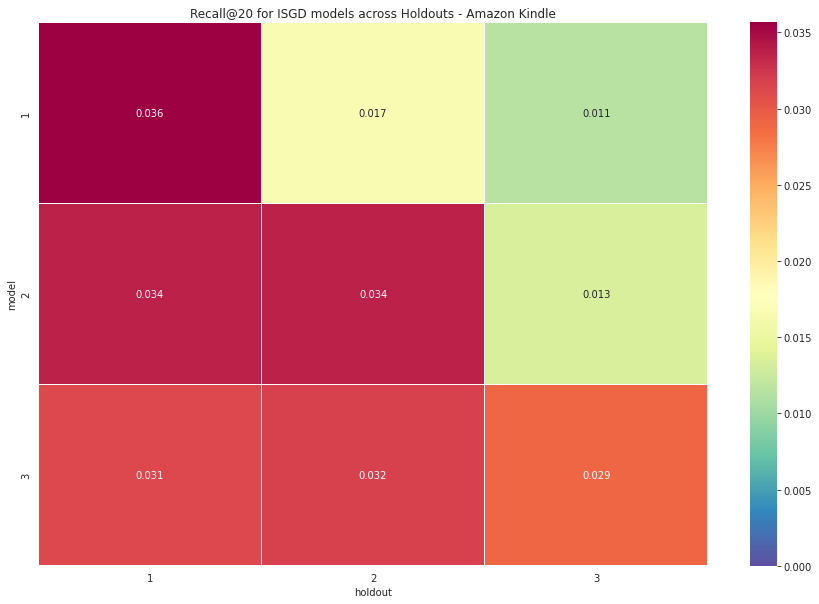

In [29]:
recall_heatmap(df,
               round_point=3,
               title='Recall@20 for ISGD models across Holdouts - Amazon Kindle',
               filepath='images/heatmaps/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [30]:
arecall = avg_recall(df)
arecall

0.03280272343510076

In [31]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0020605280103026397, -0.003111014707463486], -0.0025857713588830628)

In [32]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.013867945186434036

In [33]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib')

['output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib']